In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import utils as utils

In [2]:
train_path = 'train.csv'

train_data = pd.read_csv(train_path)
train_data.describe()

,text,label
count,45706,45706
unique,45631,5
top,FEARLESS FRIDAYS MEGA THREAD. Here we discuss ...,self.depression
freq,15,15714


In [3]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert text to sequences and pad them
max_length = max([len(s.split()) for s in train_data['text']])
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])

X_data = pad_sequences(train_sequences, maxlen=max_length)

# Encode labels
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(train_data['label'])

#split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2, random_state=42)

In [7]:
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
output_units = len(label_encoder.classes_)  # Number of classes

#converting encoded labels to one_hot encoding
y_train_one_hot = to_categorical(y_train, output_units)
y_test_one_hot = to_categorical(y_test, output_units)

In [5]:
def build_model():
    model = Sequential([
        Embedding(vocab_size, 128),
        LSTM(64, activation='tanh', recurrent_dropout=0),
        Dense(output_units, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
results = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}

#loop through each percentage
for fraction in list(np.arange(0.1, 1.0, 0.1)) + [0.999]:
    model = build_model()  # Recreate the model for each iteration
    partial_X_train, _, partial_y_train, _ = train_test_split(X_train, y_train_one_hot,train_size=fraction, random_state=42)
    model.fit(partial_X_train, partial_y_train, epochs=3, batch_size=32, verbose=1)

    # Predict on X_test
    y_pred_prob = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)
    y_test_integers = np.argmax(y_test_one_hot, axis=1)

    # Calculate metrics
    precision = precision_score(y_test_integers, y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_test_integers, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_test_integers, y_pred_classes, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test_integers, y_pred_classes)

    # Store metrics
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['accuracy'].append(accuracy)

Epoch 1/3
115/115 [==============================] - 32s 257ms/step - loss: 1.5285 - accuracy: 0.3487
Epoch 2/3
115/115 [==============================] - 29s 251ms/step - loss: 1.2689 - accuracy: 0.4694
Epoch 3/3
286/286 [==============================] - 23s 78ms/step
Epoch 1/3
229/229 [==============================] - 60s 255ms/step - loss: 1.4490 - accuracy: 0.3781
Epoch 2/3
229/229 [==============================] - 54s 235ms/step - loss: 1.1499 - accuracy: 0.5313
Epoch 3/3
286/286 [==============================] - 22s 77ms/step
Epoch 1/3
343/343 [==============================] - 88s 251ms/step - loss: 1.4699 - accuracy: 0.3709
Epoch 2/3
343/343 [==============================] - 77s 225ms/step - loss: 1.3278 - accuracy: 0.4341
Epoch 3/3
286/286 [==============================] - 23s 78ms/step
Epoch 1/3
458/458 [==============================] - 116s 248ms/step - loss: 1.3907 - accuracy: 0.4155
Epoch 2/3
458/458 [==============================] - 100s 219ms/step - loss: 1.1993 

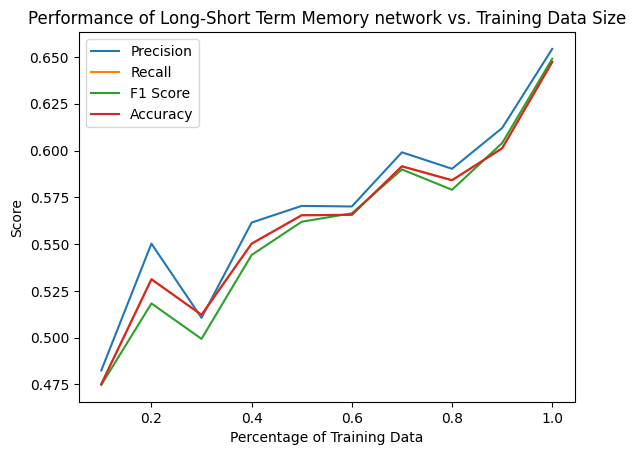

In [9]:
utils.create_graph([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], results, 'Long-Short Term Memory network', 'LSTM.png')

In [11]:
model.save('LSTM.keras')